<center>
    
 # **ACIT 4610 Mandatory 2**
 
 ## **Multi-Objective VRP: NSGA-II vs SPEA2**
 
 ## **Group nr: 3**

</center>


## **1. Data Ingestion and Setup**

- Import libraries and dependencies
- Load instance(s)
- Build distance matrix and basic helpers


In [ ]:
import math, random, time
from typing import List, Tuple, Dict
import time 
import os


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vrplib
import seaborn as sns
from scipy.spatial.distance import cdist #efficient distance matrix calculation (Euclidean distances)


# --- Reproducibility
RNG = random.Random(42)
np.random.seed(42)


In [133]:
def load_instance(path: str):
    inst = vrplib.read_instance(path)
    capacity: int = inst['capacity']
    demands = inst['demand']
    coords = inst["node_coord"]
    depot_ids = inst['depot']

    # Handle coords as dict or ndarray
    if isinstance(coords, dict):
        ordered_ids = list(sorted(coords.keys()))  # e.g., [1,2,...,n]
        coords_arr = np.array([coords[i] for i in ordered_ids], dtype=float)
    else:  # assume it's already an ndarray (shape (n,2))
        coords_arr = np.array(coords, dtype=float)
        ordered_ids = list(range(1, len(coords_arr)+1))

    demand_arr = np.array(demands, dtype=int)

    # depot index in 0-based numpy arrays
    depot_idx = depot_ids[0] - 1  # node_id=1 → index=0

    return capacity, demand_arr, coords_arr, depot_idx, ordered_ids





def distance_matrix(coords_arr: np.ndarray) -> np.ndarray:
    return cdist(coords_arr, coords_arr, metric="euclidean")
    
INST_SMALL = "A-n32-k5.vrp"
INST_MED = "B-n78-k10.vrp"
INST_LARGE = "X-n101-k25.vrp"

cap_s, dem_s, XY_s, dep_s, ids_s = load_instance(INST_SMALL)
cap_m, dem_m, XY_m, dep_m, ids_m = load_instance(INST_MED)
cap_l, dem_l, XY_l, dep_l, ids_l = load_instance(INST_LARGE)


D_s = distance_matrix(XY_s)
D_m = distance_matrix(XY_m)
D_l = distance_matrix(XY_l)


## **2. Representation & helpers**

# We use a giant-tour permutation of customers (exclude depot). A split procedure
# constructs feasible routes under capacity.


In [ ]:
class VRPInstance:
    def __init__(self, cap, demands, D, depot=0):
        self.cap = cap
        self.demands = demands
        self.D = D # distance matrix
        self.depot = depot

    def customers(self) -> np.ndarray:# return all customer indices (excluding depot)
        n = len(self.demands)
        return np.array([i for i in range(n) if i != self.depot], dtype=int)



def split_routes(tour: np.ndarray, vrp: VRPInstance) -> List[List[int]]: 
    routes: List[List[int]] = []
    cur, load = [], 0 
    for node in tour: 
        d = int(vrp.demands[node]) 
        if load + d <= vrp.cap:
            # add node to current route
            cur.append(node)
            load += d
        else:
            # finish current route and start a new one
            if cur:
                routes.append(cur)
            cur, load = [node], d

    # don’t forget to append the last route
    if cur:
        routes.append(cur)
    return routes





def route_distance(route: List[int], vrp: VRPInstance) -> float:
    if not route:
        return 0.0
    dep = vrp.depot
    dist = vrp.D[dep, route[0]]
    for i in range(len(route) - 1):
        dist += vrp.D[route[i], route[i+1]]
    dist += vrp.D[route[-1], dep]
    return float(dist)




def fitness(tour: np.ndarray, vrp: VRPInstance, penalty: float = 1e6) -> Tuple[float, float]:
    routes = split_routes(tour, vrp)

    # Loads in vectorized form
    loads = np.array([vrp.demands[r].sum() for r in routes], dtype=float)

    # Route distances in vectorized form
    dists = []
    D = vrp.D   # distance matrix (precomputed!)
    depot = vrp.depot

    for r in routes:
        if len(r) == 0:
            continue
        idx = np.array(r, dtype=int)
        # depot → first + inside legs + last → depot
        dist = D[depot, idx[0]] + D[idx[-1], depot] + np.sum(D[idx[:-1], idx[1:]])
        dists.append(dist)

    total_dist = float(np.sum(dists))
    load_std = float(loads.std()) if loads.size > 1 else 0.0

    # Penalize capacity violation (vectorized)
    over = np.maximum(0, loads - vrp.cap).sum()
    if over > 0:
        total_dist += penalty * over

    return (total_dist, load_std)





## **3.Genetic operators**



In [109]:
def init_population(vrp: VRPInstance, pop_size: int) -> List[np.ndarray]:
    base = vrp.customers().copy()
    pop = []
    for _ in range(pop_size):
        RNG.shuffle(base)
        pop.append(base.copy())
    return pop


def order_crossover(p1: np.ndarray, p2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    n = len(p1)
    a, b = sorted(RNG.sample(range(n), 2))
    def ox(pa, pb):
        child = np.full(n, -1, dtype=int)
        child[a:b+1] = pa[a:b+1]
        fill = [x for x in pb if x not in child]
        idxs = [i for i in range(n) if child[i] == -1]
        for i, v in zip(idxs, fill):
            child[i] = v
        return child
    return ox(p1, p2), ox(p2, p1)


def swap_mutation(ind: np.ndarray, pm: float = 0.1) -> np.ndarray:
    ind = ind.copy()
    n = len(ind)
    for i in range(n):
        if RNG.random() < pm:
            j = RNG.randrange(n)
            ind[i], ind[j] = ind[j], ind[i]
    return ind

## **4. Non-dominated sorting & utilities**


In [110]:
def dominates(a: tuple, b: tuple) -> bool:
    return (a[0] <= b[0] and a[1] <= b[1]) and (a != b)

def fast_nondominated_sort(F):
    """Vectorized non-dominated sort (much faster than nested loops)."""
    F = np.array(F, dtype=float)   # shape (n, m)
    n = len(F)
    S = [set() for _ in range(n)]
    n_dom = np.zeros(n, dtype=int)
    fronts = [[]]

    # ---- Vectorized dominance checks ----
    less_equal = (F[:, None, :] <= F[None, :, :])   # shape (n,n,m)
    strictly_less = (F[:, None, :] < F[None, :, :])
    dom_matrix = np.all(less_equal, axis=2) & np.any(strictly_less, axis=2)
    # dom_matrix[i,j] == True if i dominates j

    # Build S and n_dom
    for p in range(n):
        dominated = np.where(dom_matrix[p])[0]
        S[p].update(dominated.tolist())
        n_dom[p] = dom_matrix[:, p].sum()   # how many dominate p
        if n_dom[p] == 0:
            fronts[0].append(p)

    # ---- Front construction ----
    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n_dom[q] -= 1
                if n_dom[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)

    if not fronts[-1]:
        fronts.pop()
    return fronts

def crowding_distance(front_idx, F):
    """Vectorized crowding distance computation."""
    if not front_idx:
        return {}

    V = np.array([F[i] for i in front_idx], dtype=float)  # shape (n, m)
    n, m = V.shape
    distances = np.zeros(n)

    for obj in range(m):
        order = np.argsort(V[:, obj])        # sorted indices
        distances[order[0]] = np.inf         # boundary points
        distances[order[-1]] = np.inf

        vals = V[order, obj]
        vmin, vmax = vals[0], vals[-1]
        denom = (vmax - vmin) or 1.0

        # vectorized difference (next - prev)
        if n > 2:
            diff = vals[2:] - vals[:-2]
            distances[order[1:-1]] += diff / denom

    # return mapping back to original indices
    return {idx: dist for idx, dist in zip(front_idx, distances)}

def pareto_front(F):
    """Return the non-dominated points from a set of objective vectors."""
    nd = []
    for i, a in enumerate(F):
        a = tuple(a)
        if not any(dominates(tuple(b), a) for j, b in enumerate(F) if j != i):
            nd.append(a)
    return np.array(nd, dtype=float)


## **5. NSGA-II**



In [111]:
def nsga2(vrp: VRPInstance, pop_size=80, gens=200, pc=0.9, pm=0.1, return_all=False):
    # --- initialize ---
    pop = init_population(vrp, pop_size)        # list of permutations
    Fvals = [fitness(ind, vrp) for ind in pop]  # objectives
    evals = len(Fvals)

    for _ in range(gens):
        # --- fast non-dominated sort ---
        fronts = fast_nondominated_sort(Fvals)

        # --- compute ranks & crowding distance ---
        ranks = np.full(len(Fvals), np.inf)
        distances = np.zeros(len(Fvals))
        for rank, front in enumerate(fronts):
            for idx in front:
                ranks[idx] = rank
            cd = crowding_distance(front, Fvals)
            for idx, dist in cd.items():
                distances[idx] = dist

        # --- tournament selection ---
        def tournament():
            i, j = RNG.randrange(len(pop)), RNG.randrange(len(pop))
            # lower rank = better, if tie use larger crowding distance
            if (ranks[i] < ranks[j]) or (ranks[i] == ranks[j] and distances[i] > distances[j]):
                return pop[i]
            else:
                return pop[j]

        # --- offspring generation ---
        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = tournament(), tournament()
            if RNG.random() < pc:
                c1, c2 = order_crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            offspring.append(swap_mutation(c1, pm))
            offspring.append(swap_mutation(c2, pm))
        offspring = offspring[:pop_size]

        off_F = [fitness(ind, vrp) for ind in offspring]
        evals += len(off_F)

        # --- environmental selection ---
        all_pop = pop + offspring
        all_F   = Fvals + off_F
        fronts  = fast_nondominated_sort(all_F)

        new_pop, new_F = [], []
        for front in fronts:
            if len(new_pop) + len(front) <= pop_size:
                new_pop += [all_pop[i] for i in front]
                new_F   += [all_F[i] for i in front]
            else:
                # compute crowding once for the last partial front
                cd = crowding_distance(front, all_F)
                sorted_front = sorted(front, key=lambda i: cd[i], reverse=True)
                take = pop_size - len(new_pop)
                sel  = sorted_front[:take]
                new_pop += [all_pop[i] for i in sel]
                new_F   += [all_F[i] for i in sel]
                break

        pop, Fvals = new_pop, new_F

    # --- extract Pareto front ---
    PF_vals = pareto_front(np.array(Fvals))
    PF_routes = [pop[i] for i in range(len(pop)) if list(Fvals[i]) in PF_vals.tolist()]

    if return_all:
        return PF_vals, PF_routes, np.array(Fvals), evals, pop
    return PF_vals


## **6. SPEA2**



In [112]:
def spea2(vrp: VRPInstance, pop_size=80, archive_size=80, gens=200, pc=0.9, pm=0.1, k_nn=1, return_all=False):
    def assign_spea2_fitness(vals: list, k_nn: int = 1) -> np.ndarray:
        V = np.array(vals, dtype=float)
        n = len(V)
        dom_matrix = np.all(V[:, None, :] <= V[None, :, :], axis=2) & np.any(V[:, None, :] < V[None, :, :], axis=2)
        S = dom_matrix.sum(axis=1)
        R = (dom_matrix.T * S).sum(axis=1)
        dists = np.linalg.norm(V[:, None, :] - V[None, :, :], axis=2)
        np.fill_diagonal(dists, np.inf)
        neigh = np.sort(dists, axis=1)
        sigma = neigh[:, k_nn-1] if k_nn <= n-1 else neigh[:,-1]
        M = 1.0 / (sigma + 2.0)
        return R + M

    pop = init_population(vrp, pop_size)
    Fp = [fitness(ind, vrp) for ind in pop]
    evals = len(Fp)
    archive, Fa = [], []

    for _ in range(gens):
        union = archive + pop
        Fu = Fa + Fp
        fit = assign_spea2_fitness(Fu)
        idx_sorted = np.argsort(fit)
        archive = [union[i] for i in idx_sorted[:archive_size]]
        Fa = [Fu[i] for i in idx_sorted[:archive_size]]

        def tour_from_archive():
            i, j = RNG.randrange(len(archive)), RNG.randrange(len(archive))
            return archive[i] if sum(Fa[i]) < sum(Fa[j]) else archive[j]

        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = tour_from_archive(), tour_from_archive()
            if RNG.random() < pc:
                c1, c2 = order_crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            offspring.extend([swap_mutation(c1, pm), swap_mutation(c2, pm)])
        pop = offspring[:pop_size]
        Fp = [fitness(ind, vrp) for ind in pop]
        evals += len(Fp)

    # Extract Pareto front
    PF_vals = pareto_front(np.array(Fa))
    PF_routes = [archive[i] for i in range(len(archive)) if list(Fa[i]) in PF_vals.tolist()]

    if return_all:
        return PF_vals, PF_routes, np.array(Fa), evals, archive
    return PF_vals


## **7. Experiment and Visualization**

In [114]:
def run_experiment(vrp: VRPInstance, algo: str, seed: int = 0, **kwargs):
    RNG.seed(seed); np.random.seed(seed)
    t0 = time.time()

    if algo.lower() == "nsga2":
        PF_vals, PF_routes, F, evals, pop = nsga2(vrp, return_all=True, **kwargs)
    elif algo.lower() == "spea2":
        PF_vals, PF_routes, F, evals, pop = spea2(vrp, return_all=True, **kwargs)
    else:
        raise ValueError(f"Unknown algo {algo}")

    runtime = time.time() - t0
    return {
        "algo": algo,
        "seed": seed,
        "PF": PF_vals,        # objectives
        "PF_routes": PF_routes, # permutations for PF
        "F": F,               # objectives of full pop
        "runtime": runtime,
        "evals": evals
    }


In [ ]:
# --- Experiment driver (with incremental saving, corrected) ---
, time, pandas as pd, numpy as np, random as RNG

# Parameter sets (assignment requires 3)
PARAM_SETS = [
    {"pop_size": 100, "gens": 500, "pc": 0.7,  "pm": 0.2},
    {"pop_size": 80,  "gens": 300, "pc": 0.9,  "pm": 0.1},
    {"pop_size": 120, "gens": 600, "pc": 0.8,  "pm": 0.15},
]

N_RUNS = 20   # 🔹 quick test (set to 20 later)
ALGORITHMS = ["nsga2", "spea2"]
INSTANCES = {"S": vrp_S, "M": vrp_M, "L": vrp_L}

def run_all_experiments():
    save_path = "results_incremental.pkl"
    if os.path.exists(save_path):
        df_prev = pd.read_pickle(save_path)
        records = df_prev.to_dict("records")
    else:
        records = []

    def is_done(inst_name, algo, p_idx, seed):
        return any(r["instance"]==inst_name and r["algo"]==algo and
                   r["param_set"]==p_idx and r["seed"]==seed for r in records)

    for inst_name, vrp in INSTANCES.items():
        for algo in ALGORITHMS:
            # Start enumerate at 1 so param_set = 1,2,3
            for p_idx, params in enumerate(PARAM_SETS, start=1):
                for seed in range(N_RUNS):
                    if is_done(inst_name, algo, p_idx, seed):
                        continue
                    res = run_experiment(vrp, algo, seed=seed, **params)

                    # Save everything, including PF_routes
                    records.append({
                        "instance": inst_name,
                        "algo": algo,
                        "param_set": p_idx,
                        "seed": seed,
                        "runtime": res["runtime"],
                        "evals": res["evals"],
                        "F": res["F"],
                        "PF": res["PF"],
                        "PF_routes": res.get("PF_routes", None)
                    })

                    # Save after each run
                    pd.DataFrame(records).to_pickle(save_path)
                    print(f"[{inst_name} | {algo} | set {p_idx} | seed {seed}] "
                          f"runtime={res['runtime']:.2f}s, evals={res['evals']} saved")

    return pd.DataFrame(records)

# --- Run a small test ---
df_results = run_all_experiments()

# Build global reference front
if len(df_results) > 0:
    all_PFs = np.vstack(df_results["PF"].dropna().values)
    ref_set = pareto_front(all_PFs)
    np.save("reference_front.npy", ref_set)
    print("Reference front saved with shape:", ref_set.shape)


[S | nsga2 | set 1 | seed 0] runtime=12.56s, evals=50100 saved
[S | nsga2 | set 1 | seed 1] runtime=12.59s, evals=50100 saved
[S | nsga2 | set 1 | seed 2] runtime=12.39s, evals=50100 saved
[S | nsga2 | set 1 | seed 3] runtime=12.55s, evals=50100 saved
[S | nsga2 | set 1 | seed 4] runtime=12.39s, evals=50100 saved
[S | nsga2 | set 1 | seed 5] runtime=12.37s, evals=50100 saved
[S | nsga2 | set 1 | seed 6] runtime=12.27s, evals=50100 saved
[S | nsga2 | set 1 | seed 7] runtime=12.39s, evals=50100 saved
[S | nsga2 | set 1 | seed 8] runtime=12.21s, evals=50100 saved
[S | nsga2 | set 1 | seed 9] runtime=12.28s, evals=50100 saved
[S | nsga2 | set 1 | seed 10] runtime=12.52s, evals=50100 saved
[S | nsga2 | set 1 | seed 11] runtime=12.34s, evals=50100 saved
[S | nsga2 | set 1 | seed 12] runtime=12.35s, evals=50100 saved
[S | nsga2 | set 1 | seed 13] runtime=13.44s, evals=50100 saved
[S | nsga2 | set 1 | seed 14] runtime=12.36s, evals=50100 saved
[S | nsga2 | set 1 | seed 15] runtime=12.28s, eval

C:\Users\welde\AppData\Local\Temp\ipykernel_20828\2875839079.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(routes))


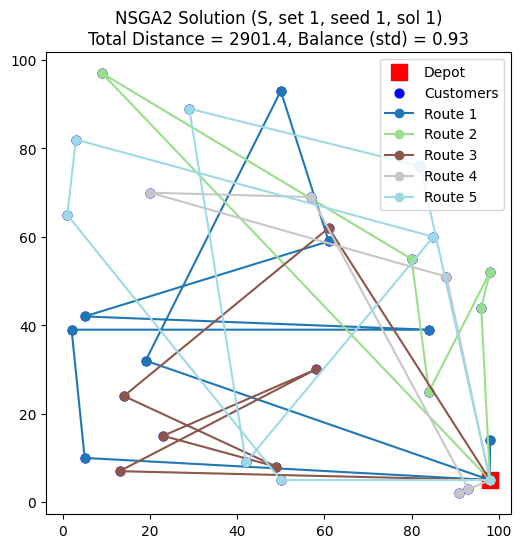

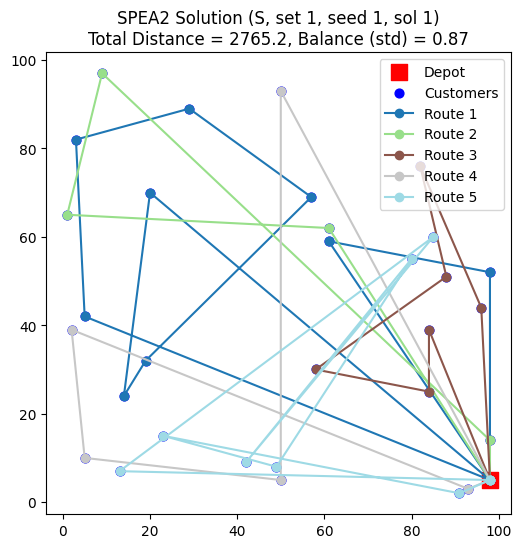

In [130]:

# --- Decode a solution permutation into routes ---
def decode_routes(solution, demands, capacity, depot_idx=0):
    """Split a permutation into capacity-feasible routes."""
    routes = []
    load = 0
    route = [depot_idx]
    for cust in solution:
        d = demands[cust]
        if load + d <= capacity:
            route.append(cust)
            load += d
        else:
            route.append(depot_idx)
            routes.append(route)
            route = [depot_idx, cust]
            load = d
    route.append(depot_idx)
    routes.append(route)
    return routes

# --- Plot routes on a map ---
def plot_solution_routes(routes, coords, depot_idx=0, title="Solution Routes", obj=None):
    plt.figure(figsize=(6,6))

    # plot depot
    plt.scatter(coords[depot_idx,0], coords[depot_idx,1], 
                c="red", marker="s", s=120, label="Depot")

    # plot customers
    cust_idx = [i for i in range(len(coords)) if i != depot_idx]
    plt.scatter(coords[cust_idx,0], coords[cust_idx,1], 
                c="blue", marker="o", s=40, label="Customers")

    # draw routes
    colors = plt.cm.get_cmap("tab20", len(routes))
    for r_idx, route in enumerate(routes):
        xs = coords[route,0]
        ys = coords[route,1]
        plt.plot(xs, ys, marker="o", color=colors(r_idx), label=f"Route {r_idx+1}")

    # Add objectives in the title if provided
    if obj is not None:
        title += f"\nTotal Distance = {obj[0]:.1f}, Balance (std) = {obj[1]:.2f}"

    plt.title(title)
    plt.legend()
    plt.show()

# --- Unified function to select and plot one solution ---
def plot_run_solution(df, instance, algo, param_set, seed, sol_idx=0):
    """Plot one Pareto solution from df_results based on instance, algo, param_set, seed."""
    row = df[(df["instance"]==instance) & 
             (df["algo"]==algo) & 
             (df["param_set"]==param_set) & 
             (df["seed"]==seed)].iloc[0]

    # select one solution from Pareto front
    solution_perm = row["PF_routes"][sol_idx]
    obj_values = row["PF"][sol_idx]   # (total distance, std/balance)

    # choose the right problem data
    if instance == "S":
        demands, capacity, coords, depot_idx = dem_s, cap_s, XY_s, dep_s
    elif instance == "M":
        demands, capacity, coords, depot_idx = dem_m, cap_m, XY_m, dep_m
    else:
        demands, capacity, coords, depot_idx = dem_l, cap_l, XY_l, dep_l

    # decode and plot
    routes = decode_routes(solution_perm, demands, capacity, depot_idx)
    plot_solution_routes(routes, coords, depot_idx, 
                         title=f"{algo.upper()} Solution ({instance}, set {param_set}, seed {seed}, sol {sol_idx})",
                         obj=obj_values)

# --- Examples ---
# NSGA-II
plot_run_solution(df_results, "S", "nsga2", 1, 1, sol_idx=1)

# SPEA2
plot_run_solution(df_results, "S", "spea2", 1, 1, sol_idx=1)

Loaded runs: (360, 9)
  instance   algo  param_set  seed    runtime  evals  \
0        S  nsga2          1     0  12.559103  50100   
1        S  nsga2          1     1  12.594244  50100   
2        S  nsga2          1     2  12.390250  50100   
3        S  nsga2          1     3  12.550180  50100   
4        S  nsga2          1     4  12.388164  50100   

                                                   F  \
0  [[2044.7837308757396, 8.491723912139395], [204...   
1  [[2286.6608401045296, 2.8722813232690143], [29...   
2  [[2035.7605979180412, 10.885052824860336], [22...   
3  [[2066.9307461181133, 5.612486080160912], [214...   
4  [[2595.1876948714585, 1.920286436967152], [242...   

                                                  PF  \
0  [[2044.7837308757396, 8.491723912139395], [204...   
1  [[2286.6608401045296, 2.8722813232690143], [29...   
2  [[2035.7605979180412, 10.885052824860336], [22...   
3  [[2066.9307461181133, 5.612486080160912], [214...   
4  [[2595.1876948714585,

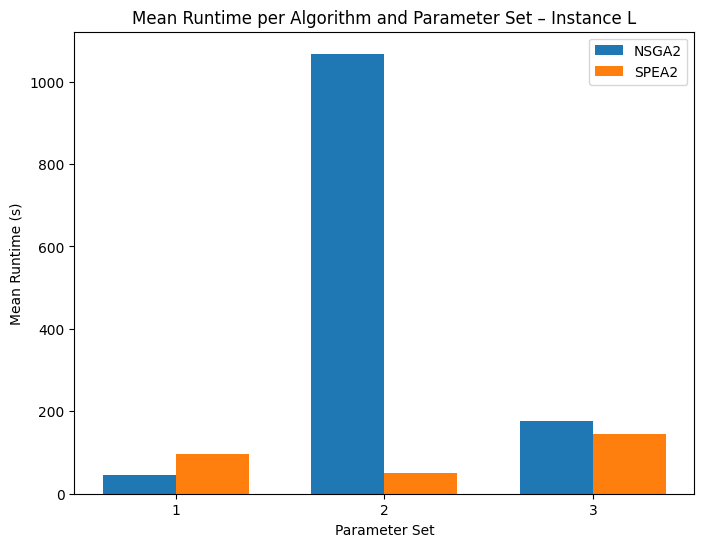

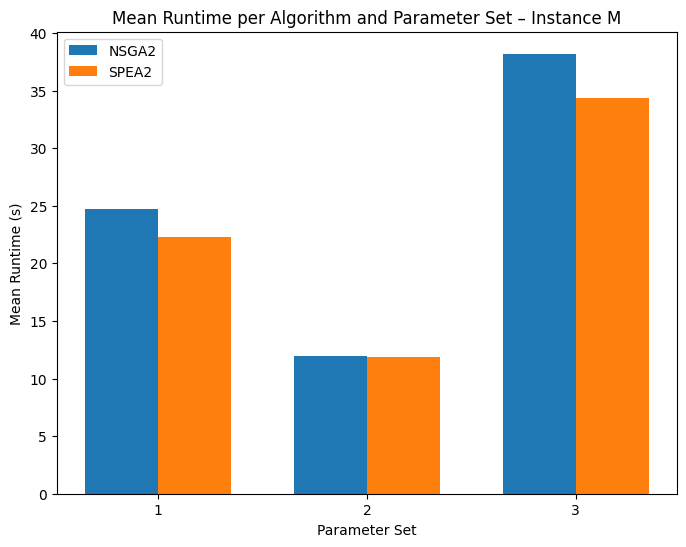

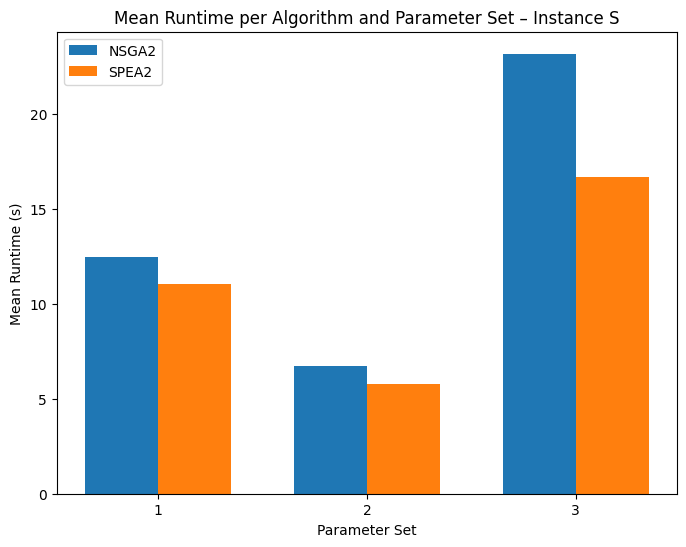

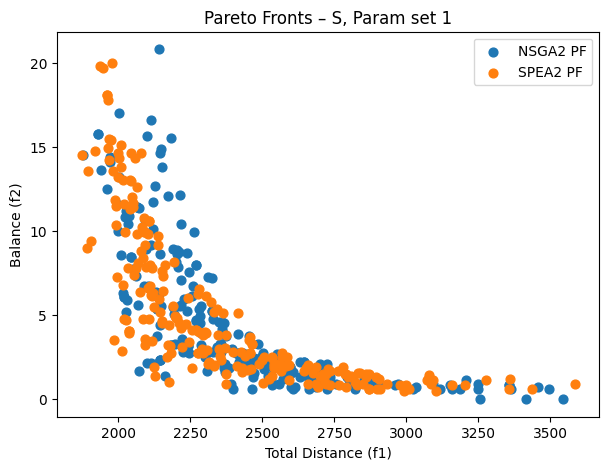

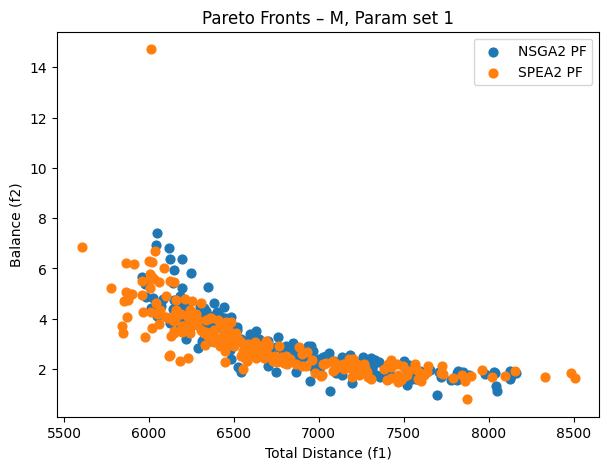

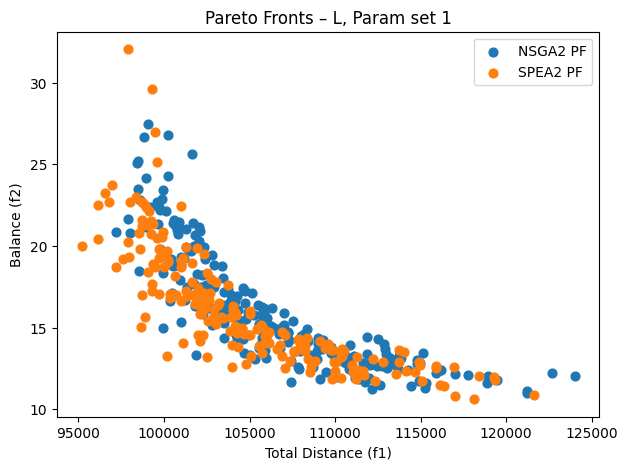

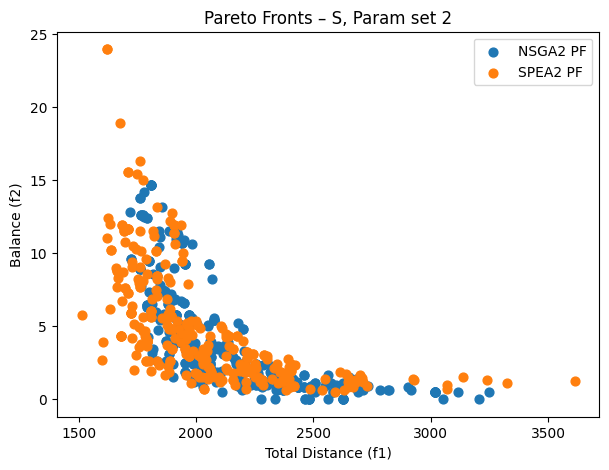

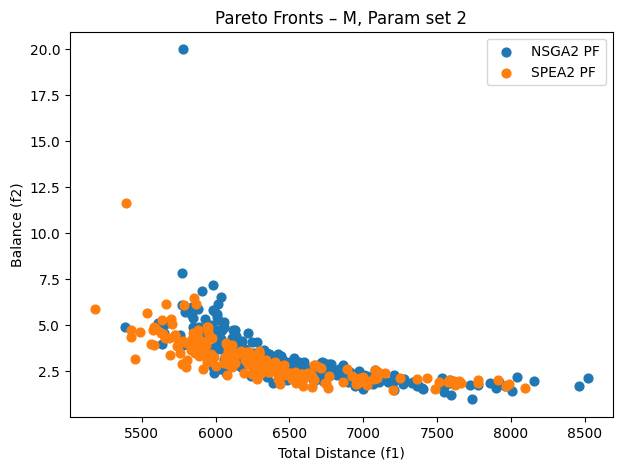

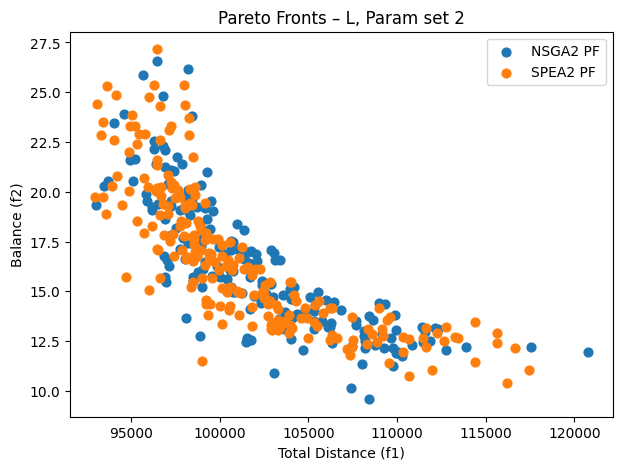

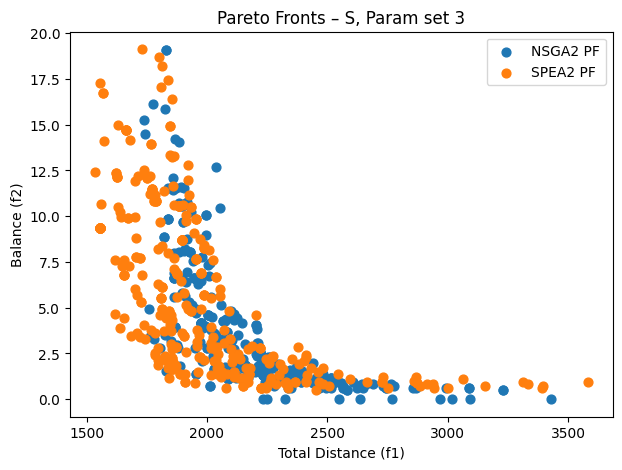

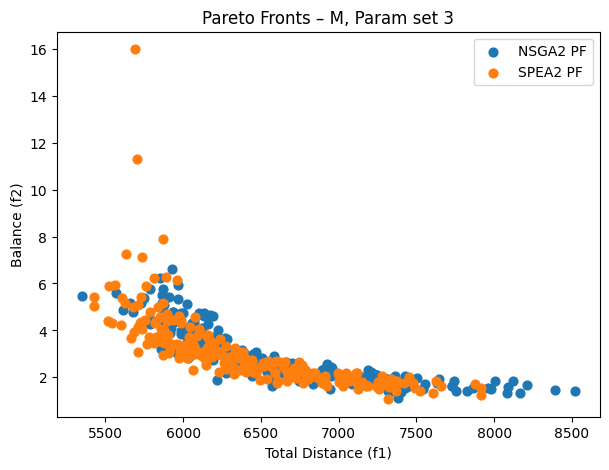

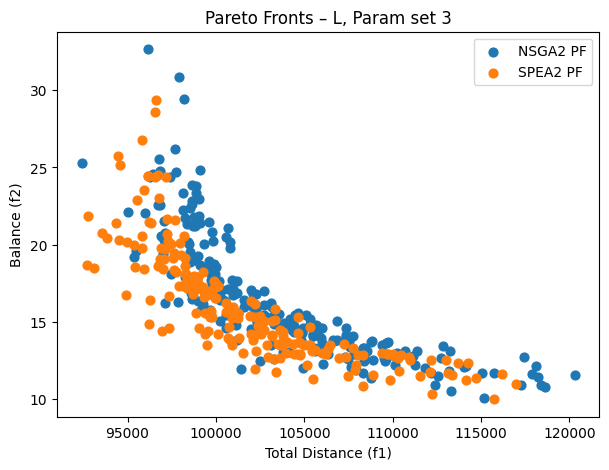

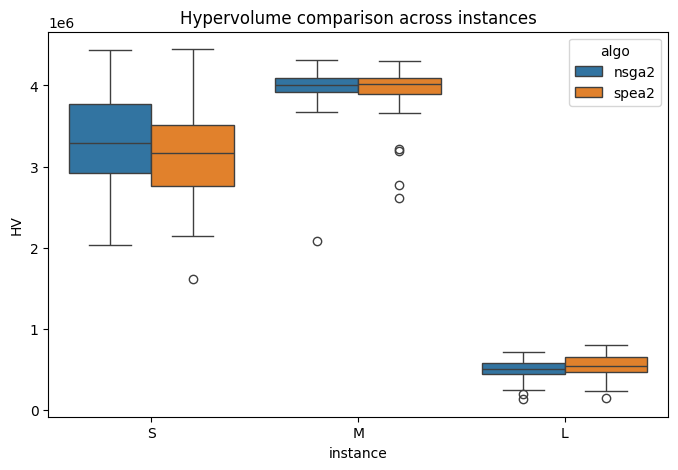

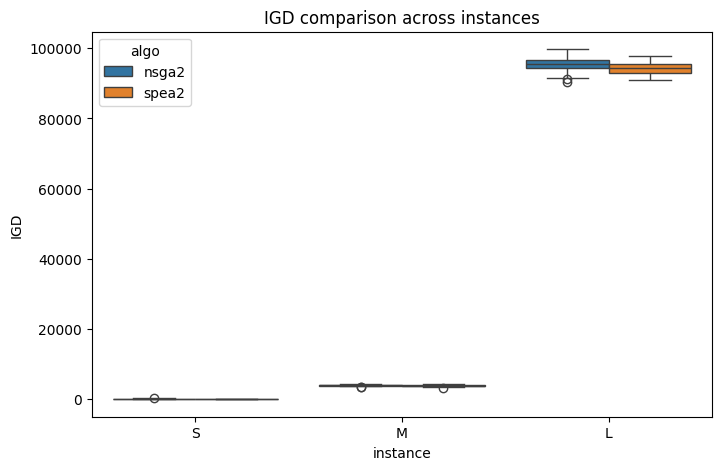

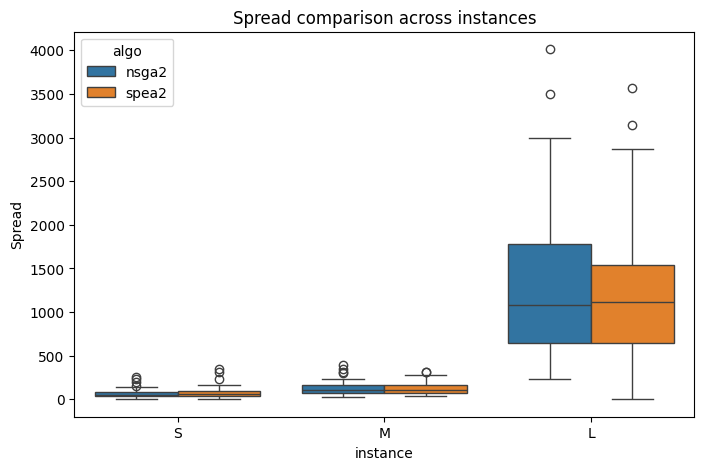

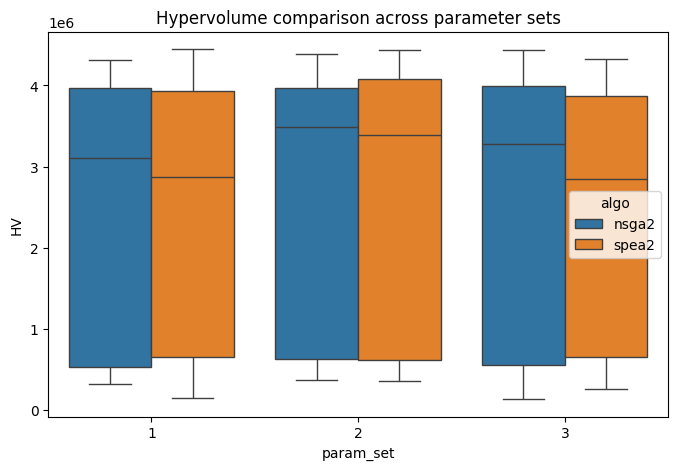

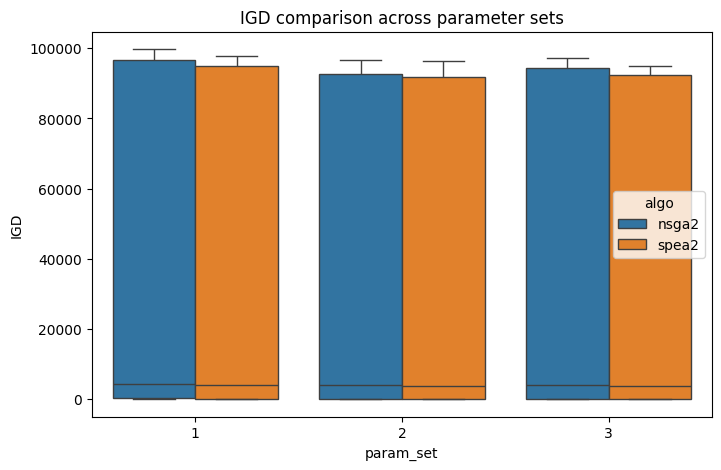

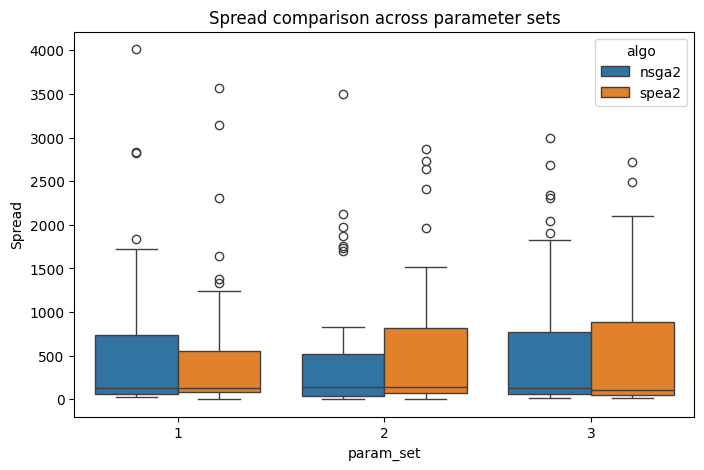

In [131]:


# Load your saved experiment results
df_results = pd.read_pickle("results_incremental.pkl")
print("Loaded runs:", df_results.shape)
print(df_results.head())

# === Runtime & evaluations summary ===
runtime_summary = (
    df_results.groupby(["instance","algo","param_set"])
    .agg({
        "runtime": ["min","mean","std","max"],
        "evals": ["min","mean","std","max"]
    })
    .round(3)
)
print("\n--- Runtime Summary ---")
print(runtime_summary)

# === Reference Pareto front ===
def pareto_front(points):
    """Simple non-dominated filter."""
    is_efficient = np.ones(points.shape[0], dtype=bool)
    for i, p in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(points[is_efficient] < p, axis=1) | np.all(points[is_efficient] == p, axis=1)
            is_efficient[i] = True
    return points[is_efficient]

all_PFs = np.vstack(df_results["PF"].dropna().values)
ref_set = pareto_front(all_PFs)
ref_point = all_PFs.max(axis=0) * 1.1
print("Reference front shape:", ref_set.shape)

# === Metric functions ===
def compute_hv(PF, ref_point):
    """Compute 2D hypervolume assuming minimization in both objectives."""
    if len(PF) == 0:
        return 0.0
    # Sort by first objective (f1 = distance)
    PF = PF[np.argsort(PF[:,0])]
    hv = 0.0
    prev_f1 = ref_point[0]
    for f1, f2 in PF:
        width = prev_f1 - f1
        height = ref_point[1] - f2
        if width > 0 and height > 0:
            hv += width * height
        prev_f1 = f1
    return hv

def compute_igd(PF, ref_set):
    if len(PF) == 0 or len(ref_set) == 0:
        return np.inf
    dists = cdist(ref_set, PF)
    return np.mean(np.min(dists, axis=1))

def compute_spread(PF):
    if len(PF) < 2:
        return np.inf
    dists = np.linalg.norm(PF[:, None, :] - PF[None, :, :], axis=-1)
    np.fill_diagonal(dists, np.inf)
    nearest = np.min(dists, axis=1)
    return np.std(nearest)

# === Compute metrics for each run ===
metrics = []
for idx, row in df_results.iterrows():
    PF = row["PF"]
    metrics.append({
        "instance": row["instance"],
        "algo": row["algo"],
        "param_set": row["param_set"],
        "seed": row["seed"],
        "HV": compute_hv(PF, ref_point),
        "IGD": compute_igd(PF, ref_set),
        "Spread": compute_spread(PF),
        "runtime": row["runtime"],
        "evals": row["evals"]
    })

df_metrics = pd.DataFrame(metrics)
print("\n--- Metrics per run ---")
print(df_metrics.head())

# === Aggregated metrics summary ===
metrics_summary = (
    df_metrics.groupby(["instance","algo","param_set"])
    .agg({
        "HV": ["mean","std"],
        "IGD": ["mean","std"],
        "Spread": ["mean","std"],
        "runtime": ["mean","std"],
        "evals": ["mean","std"]
    })
    .round(3)
)
print("\n--- Metrics Summary ---")
print(metrics_summary)

# === Pareto scatter plots ===
def plot_pareto_fronts(df, instance, param_set):
    plt.figure(figsize=(7,5))
    algo_colors = {"nsga2": "tab:blue", "spea2": "tab:orange"}

    for algo in ["nsga2","spea2"]:
        runs = df[(df["instance"]==instance) & 
                  (df["param_set"]==param_set) & 
                  (df["algo"]==algo)]
        for i, row in runs.iterrows():
            F, PF = row["F"], row["PF"]
            plt.scatter(PF[:,0], PF[:,1], 
                        color=algo_colors[algo], marker="o", s=40, 
                        label=f"{algo.upper()} PF" if i == runs.index[0] else "")

    plt.xlabel("Total Distance (f1)")
    plt.ylabel("Balance (f2)")
    plt.title(f"Pareto Fronts – {instance}, Param set {param_set}")
    plt.legend()
    plt.show()
def plot_mean_runtime_by_instance(df):
    """Plot mean runtime per algorithm and parameter set, separately for each instance (S, M, L)."""
    runtime_means = (
        df.groupby(["instance","algo","param_set"])["runtime"]
        .mean()
        .reset_index()
    )

    instances = sorted(runtime_means["instance"].unique())
    bar_width = 0.35

    for inst in instances:
        subset = runtime_means[runtime_means["instance"] == inst]

        plt.figure(figsize=(8,6))
        param_sets = sorted(subset["param_set"].unique())
        x = range(len(param_sets))

        for i, algo in enumerate(subset["algo"].unique()):
            algo_subset = subset[subset["algo"] == algo]
            plt.bar([p + i*bar_width for p in x],
                    algo_subset["runtime"], width=bar_width, label=algo.upper())

        plt.xticks([p + bar_width/2 for p in x], param_sets)
        plt.xlabel("Parameter Set")
        plt.ylabel("Mean Runtime (s)")
        plt.title(f"Mean Runtime per Algorithm and Parameter Set – Instance {inst}")
        plt.legend()
        plt.show()


plot_mean_runtime_by_instance(df_metrics)


# Example plot: small instance, param_set
plot_pareto_fronts(df_results, "S", 1)
plot_pareto_fronts(df_results, "M", 1)
plot_pareto_fronts(df_results, "L", 1)  
plot_pareto_fronts(df_results, "S", 2)
plot_pareto_fronts(df_results, "M", 2)
plot_pareto_fronts(df_results, "L", 2)  
plot_pareto_fronts(df_results, "S", 3)
plot_pareto_fronts(df_results, "M", 3)          
plot_pareto_fronts(df_results, "L", 3)

# === Boxplots comparing algorithms ===
plt.figure(figsize=(8,5))
sns.boxplot(data=df_metrics, x="instance", y="HV", hue="algo")
plt.title("Hypervolume comparison across instances")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_metrics, x="instance", y="IGD", hue="algo")
plt.title("IGD comparison across instances")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_metrics, x="instance", y="Spread", hue="algo")
plt.title("Spread comparison across instances")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_metrics, x="param_set", y="HV", hue="algo")
plt.title("Hypervolume comparison across parameter sets")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_metrics, x="param_set", y="IGD", hue="algo")
plt.title("IGD comparison across parameter sets")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_metrics, x="param_set", y="Spread", hue="algo")
plt.title("Spread comparison across parameter sets")
plt.show()
